# 모듈 경로 설정

In [132]:
import sys, os

# 현재 파일 기준으로 두 단계 상위(= emotion_letter/)
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("PYTHONPATH:", project_root)

PYTHONPATH: c:\emotion_letter


# OCR 결과 가져오기

In [133]:
# OCR 결과 가져오기
from app.backend.services.letter.letter_ocr_service import run_gcp_ocr_with_boxes
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import vision
from typing import Dict, Any, List


image_path = "C:/emotion_letter/app/tests/data/sample_letter2.jpg"
ocr_result = run_gcp_ocr_with_boxes(image_path)
boxes = ocr_result["boxes"]

print("인식된 박스 개수:", len(boxes))

인식된 박스 개수: 37


# 단어 단위 OCR 함수 (텍스트 + bounding box)

In [134]:
def run_gcp_ocr_words(image_path: str) -> List[Dict[str, Any]]:
    client = vision.ImageAnnotatorClient()
    with open(image_path, "rb") as f:
        content = f.read()

    image = vision.Image(content=content)
    response = client.document_text_detection(image=image)

    if response.error.message:
        raise Exception(f"Vision API Error: {response.error.message}")

    words = []
    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    word_text = "".join([s.text for s in word.symbols])
                    vertices = [(v.x, v.y) for v in word.bounding_box.vertices]
                    xs = [v[0] for v in vertices if v[0] is not None]
                    ys = [v[1] for v in vertices if v[1] is not None]
                    if xs and ys:
                        words.append(
                            {
                                "text": word_text,
                                "coords": (min(xs), min(ys), max(xs), max(ys)),
                            }
                        )
    return words

# 줄 단위 OCR 함수 (텍스트 + bounding box)

In [135]:
def run_gcp_ocr_lines(image_path: str) -> List[Dict[str, Any]]:
    client = vision.ImageAnnotatorClient()
    with open(image_path, "rb") as f:
        content = f.read()

    image = vision.Image(content=content)
    response = client.document_text_detection(image=image)

    if response.error.message:
        raise Exception(f"Vision API Error: {response.error.message}")

    lines = []
    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                # 문단(줄) 단위 텍스트와 전체 좌표 묶기
                line_text = ""
                all_vertices = []

                for word in paragraph.words:
                    word_text = "".join([s.text for s in word.symbols])
                    line_text += word_text + " "
                    all_vertices.extend(
                        [(v.x, v.y) for v in word.bounding_box.vertices]
                    )

                if not line_text.strip():
                    continue

                # 전체 문단을 포함하는 bounding box 계산
                xs = [v[0] for v in all_vertices if v[0] is not None]
                ys = [v[1] for v in all_vertices if v[1] is not None]
                if not xs or not ys:
                    continue

                x_min, y_min, x_max, y_max = min(xs), min(ys), max(xs), max(ys)

                lines.append(
                    {"text": line_text.strip(), "coords": (x_min, y_min, x_max, y_max)}
                )

    return lines

# Crop 함수

In [136]:
def crop_regions(
    image_path: str, boxes: List[Dict[str, Any]], padding: int = 10
) -> List[Dict[str, Any]]:
    img = cv2.imread(image_path)
    h, w, _ = img.shape
    crops = []

    for box in boxes:
        x_min, y_min, x_max, y_max = box["coords"]
        x_min = max(0, x_min - padding)
        y_min = max(0, y_min - padding)
        x_max = min(w, x_max + padding)
        y_max = min(h, y_max + padding)

        crop = img[y_min:y_max, x_min:x_max]
        if crop.size == 0:
            continue

        crops.append(
            {"text": box["text"], "image": crop, "coords": (x_min, y_min, x_max, y_max)}
        )
    return crops

# 투명 배경 변환

In [137]:
def make_transparent_clean(crop: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)

    # 글자 픽셀만 추출 (Otsu threshold 반전)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 작은 점/노이즈 제거
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # 외곽선 부드럽게 (GaussianBlur → 알파 채널 부드럽게)
    mask = cv2.GaussianBlur(mask, (3, 3), 0)

    # BGR + 알파 합치기
    b, g, r = cv2.split(crop)
    rgba = cv2.merge([b, g, r, mask])
    return rgba

# 알파 블렌딩

In [138]:
def overlay_image_alpha(bg: np.ndarray, fg: np.ndarray, x: int, y: int) -> np.ndarray:
    h, w = fg.shape[:2]
    if y + h > bg.shape[0] or x + w > bg.shape[1]:
        return bg

    roi = bg[y : y + h, x : x + w]
    fg_bgr = fg[:, :, :3]
    alpha = fg[:, :, 3] / 255.0

    for c in range(3):
        roi[:, :, c] = (1 - alpha) * roi[:, :, c] + alpha * fg_bgr[:, :, c]

    bg[y : y + h, x : x + w] = roi
    return bg

# 시각화 도구

In [139]:
def visualize_crops(crops: List[Dict[str, Any]], n: int = 5):
    plt.figure(figsize=(15, 6))
    for i, c in enumerate(crops[:n]):
        plt.subplot(1, n, i + 1)
        plt.imshow(cv2.cvtColor(c["image"], cv2.COLOR_BGR2RGB))
        plt.title(c["text"])
        plt.axis("off")
    plt.show()

# 자동 비율 스케일링 함수

In [140]:
def fit_to_background(orig_w, orig_h, bg_w, bg_h):
    """
    OCR 원본과 편지지 배경의 비율 차이를 자동으로 맞춰주는 함수
    - 원본 비율을 유지하면서 배경에 맞게 스케일링
    - 남는 여백은 중앙 정렬
    """
    # 비율 계산
    scale_x = bg_w / orig_w
    scale_y = bg_h / orig_h

    # 가장 작은 스케일 선택 (비율 유지)
    scale = min(scale_x, scale_y)

    # 비율 유지된 실제 크기
    new_w = int(orig_w * scale)
    new_h = int(orig_h * scale)

    # 중앙 정렬 여백 계산
    offset_x = (bg_w - new_w) // 2
    offset_y = (bg_h - new_h) // 2

    return scale, offset_x, offset_y

# 어떤 배경에도 합성을 위한 코드 패턴

In [141]:
def overlay_on_background(bg_path, line_crops, orig_w, orig_h):
    bg = cv2.imread(bg_path)
    bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
    bg_h, bg_w, _ = bg.shape

    scale, offset_x, offset_y = fit_to_background(orig_w, orig_h, bg_w, bg_h)

    bg_copy = bg.copy()
    for c in line_crops:
        rgba_line = make_transparent_clean(c["image"])
        x_min, y_min, _, _ = c["coords"]

        x = int(x_min * scale) + offset_x
        y = int(y_min * scale) + offset_y

        bg_copy = overlay_image_alpha(bg_copy, rgba_line, x, y)

    return bg_copy

# 실행 예시

## 단어 단위 테스팅

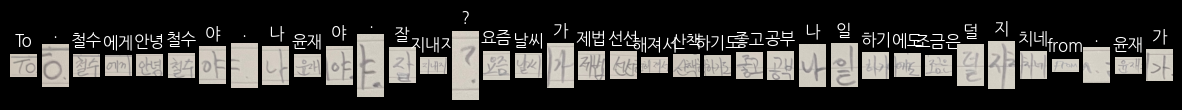

In [142]:
words = run_gcp_ocr_words(image_path)
word_crops = crop_regions(image_path, words, padding=10)
visualize_crops(word_crops, n=37)

## 줄 단위 테스팅

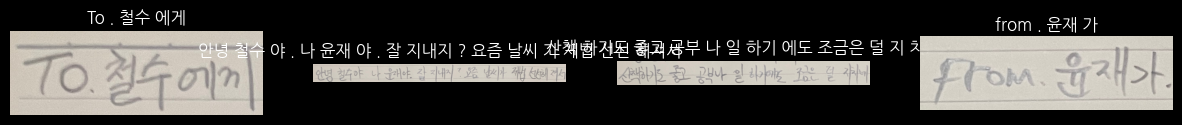

In [143]:
lines = run_gcp_ocr_lines(image_path)
line_crops = crop_regions(image_path, lines, padding=20)
visualize_crops(line_crops, n=4)

## 알파 블렌딩 - 줄 단위 테스팅

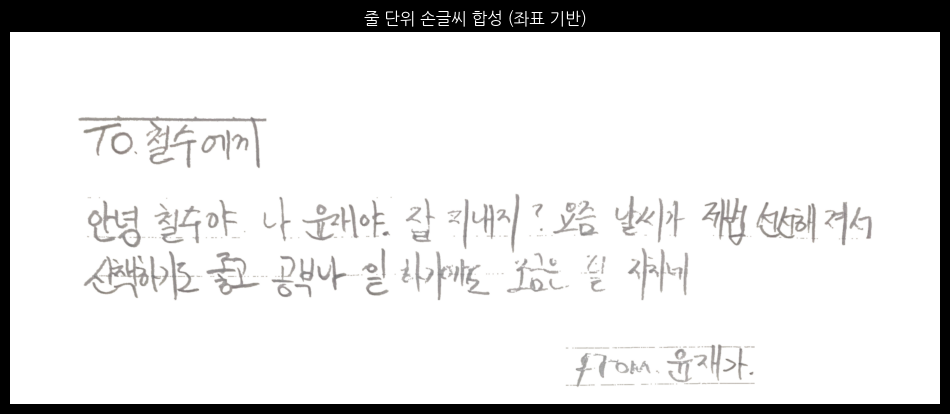

In [144]:
bg = np.ones((1200, 3000, 3), dtype=np.uint8) * 255  # 캔버스 크기 넉넉하게

for i, c in enumerate(line_crops):
    rgba_line = make_transparent_clean(c["image"])
    x_min, y_min, x_max, y_max = c["coords"]

    # OCR 좌표계는 (x, y), OpenCV는 (y, x)라서 순서 바꿔줘야 함
    bg = overlay_image_alpha(bg, rgba_line, x_min, y_min)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(bg, cv2.COLOR_BGR2RGB))
plt.title("줄 단위 손글씨 합성 (좌표 기반)")
plt.axis("off")
plt.show()

## 자동 비율 적용

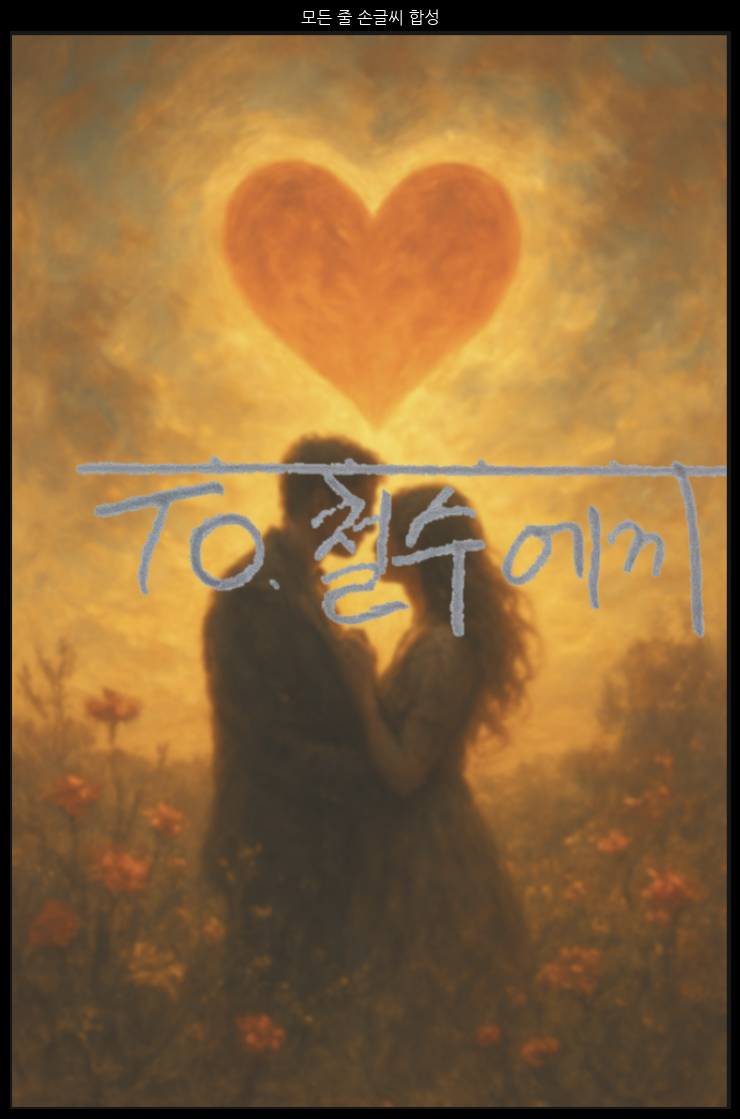

In [147]:
# 배경 이미지 준비
bg = cv2.imread("C:/emotion_letter/app/tests/data/bgimg.png")
bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
bg_h, bg_w, _ = bg.shape

# 원본 크기
orig_img = cv2.imread("C:/emotion_letter/app/tests/data/sample_letter2.jpg")
orig_h, orig_w, _ = orig_img.shape

# 비율 맞추기
scale, offset_x, offset_y = fit_to_background(orig_w, orig_h, bg_w, bg_h)

# 줄 단위 전체 합성
bg_copy = bg.copy()
for i, c in enumerate(line_crops):
    rgba_line = make_transparent_clean(c["image"])
    x_min, y_min, x_max, y_max = c["coords"]

    # 좌표 변환
    x = int(x_min * scale) + offset_x
    y = int(y_min * scale) + offset_y

    bg_copy = overlay_image_alpha(bg_copy, rgba_line, x, y)

# 결과 시각화
plt.figure(figsize=(10, 14))
plt.imshow(bg_copy)
plt.title("모든 줄 손글씨 합성")
plt.axis("off")
plt.show()

# 디버깅

In [146]:
print("감지된 줄 개수:", len(line_crops))
for i, c in enumerate(line_crops):
    print(
        f"{i+1}번째 줄: '{c['text']}' coords={c['coords']} crop_shape={c['image'].shape}"
    )

감지된 줄 개수: 4
1번째 줄: 'To . 철수 에게' coords=(204, 242, 827, 449) crop_shape=(207, 623, 3)
2번째 줄: '안녕 철수 야 . 나 윤재 야 . 잘 지내지 ? 요즘 날씨 가 제법 선선 해져서' coords=(221, 506, 2784, 692) crop_shape=(186, 2563, 3)
3번째 줄: '산책 하기도 좋고 공부 나 일 하기 에도 조금은 덜 지 치네' coords=(227, 678, 2203, 865) crop_shape=(187, 1976, 3)
4번째 줄: 'from . 윤재 가' coords=(1793, 983, 2402, 1159) crop_shape=(176, 609, 3)
